In [ ]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
from plotnine import *
import missingno as msno
import matplotlib.pyplot as plt

In [ ]:
#한글 출력
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and direc

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 격자별_포인트.csv to 격자별_포인트.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving 서울시 양천구 공영주차장.csv to 서울시 양천구 공영주차장.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving 서울시 양천구 버스정류장.csv to 서울시 양천구 버스정류장.csv


In [6]:
import pandas as pd
from pyproj import Transformer

# CSV 파일 읽기
df = pd.read_csv('격자별_포인트.csv')

# 좌표 변환 객체 생성
transformer = Transformer.from_crs("EPSG:5179", "EPSG:4326")

# 좌표 변환 수행
df['위도'], df['경도'] = transformer.transform(df['ycoord'].values, df['xcoord'].values)

# 결과 확인
print(df[['경도', '위도']].head())

df.to_csv('grid_with_latlon.csv', index=False)


           경도         위도
0  126.822517  37.510214
1  126.822476  37.514720
2  126.822456  37.516973
3  126.822313  37.532746
4  126.822293  37.534999


In [7]:
grid_points = pd.read_csv('grid_with_latlon.csv')
parking_lots = pd.read_csv('서울시 양천구 공영주차장.csv')
bus_stops = pd.read_csv('서울시 양천구 버스정류장.csv')

In [ ]:
pip install geopandas shapely pandas

In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans

# 데이터 불러오기
grids = pd.read_csv('grid_with_latlon.csv')
grids_gdf = gpd.GeoDataFrame(grids, geometry=gpd.points_from_xy(grids.경도, grids.위도))

# 가정: 버스정류장과 주차장 데이터에 '위도', '경도'라는 컬럼 이름으로 좌표 정보가 저장되어 있음
bus_stops = gpd.read_file('서울시 양천구 버스정류장.csv')
bus_stops_gdf = gpd.GeoDataFrame(bus_stops, geometry=gpd.points_from_xy(bus_stops.경도, bus_stops.위도))

parking_lots = gpd.read_file('서울시 양천구 공영주차장.csv')
# NaN 혹은 비어있는 값 제거
parking_lots = parking_lots.dropna(subset=['경도', '위도'])
parking_lots = parking_lots[parking_lots['경도'] != '']
parking_lots = parking_lots[parking_lots['위도'] != '']

# '경도'와 '위도' 컬럼을 실수로 변환
parking_lots['경도'] = parking_lots['경도'].astype(float)
parking_lots['위도'] = parking_lots['위도'].astype(float)
parking_lots_gdf = gpd.GeoDataFrame(parking_lots, geometry=gpd.points_from_xy(parking_lots.경도, parking_lots.위도))

# 각 격자의 중심점에서 가장 가까운 거리 계산 함수
def nearest_distance(point, gdf):
    return gdf.distance(point).min()

# 각 격자에서 가장 가까운 버스 정류장과 주차장까지의 거리 계산
grids_gdf['bus_distance'] = grids_gdf['geometry'].apply(nearest_distance, gdf=bus_stops_gdf)
grids_gdf['parking_distance'] = grids_gdf['geometry'].apply(nearest_distance, gdf=parking_lots_gdf)

# 지수 계산 (역수를 사용)
grids_gdf['bus_index'] = 1 / (grids_gdf['bus_distance'] + 1)
grids_gdf['parking_index'] = 1 / (grids_gdf['parking_distance'] + 1)

# K-means clustering for parking lot density adjustment
desired_number_of_clusters = 10  # Set the desired number of clusters
kmeans = KMeans(n_clusters=desired_number_of_clusters, random_state=0)
grids_gdf['parking_density_cluster'] = kmeans.fit_predict(grids_gdf['parking_index'].values.reshape(-1, 1))

# Min-max normalization for 'bus_index'
min_bus_index = grids_gdf['bus_index'].min()
max_bus_index = grids_gdf['bus_index'].max()
grids_gdf['normalized_bus_index'] = (grids_gdf['bus_index'] - min_bus_index) / (max_bus_index - min_bus_index)

# Min-max normalization for 'parking_index'
min_parking_index = grids_gdf['parking_index'].min()
max_parking_index = grids_gdf['parking_index'].max()
grids_gdf['normalized_parking_index'] = (grids_gdf['parking_index'] - min_parking_index) / (max_parking_index - min_parking_index)

# 접근성 지수 계산
grids_gdf['accessibility_index'] = 0.3 * grids_gdf['normalized_bus_index'] + 0.7 * grids_gdf['normalized_parking_index']

# 접근성 지수를 내림차순으로 정렬
grids_gdf_sorted = grids_gdf.sort_values(by='accessibility_index', ascending=False)

# 접근성 지수에 따른 순위 매기기
grids_gdf_sorted['rank'] = grids_gdf_sorted['accessibility_index'].rank(ascending=False, method='min')

# 경도, 위도, 접근성 지수 및 순위를 함께 저장
grids_gdf_sorted[['경도', '위도', 'accessibility_index', 'rank']].to_csv('접근성_지수.csv', index=False)  # index를 저장하지 않도록 설정

print("접근성 지수 계산, 순위 매기기 및 저장이 완료되었습니다.")



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


접근성 지수 계산, 순위 매기기 및 저장이 완료되었습니다.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

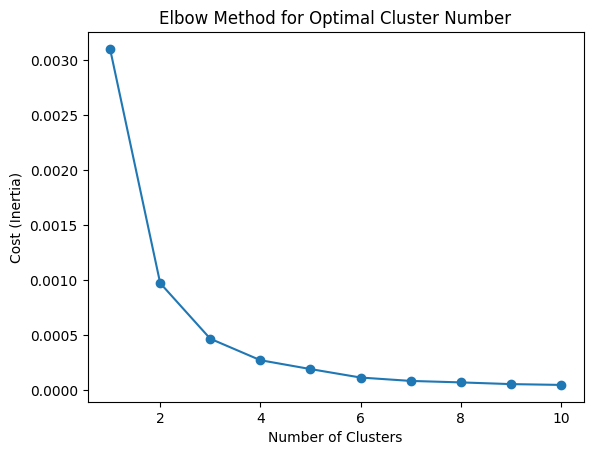

In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터 불러오기
grids = pd.read_csv('grid_with_latlon.csv')
grids_gdf = gpd.GeoDataFrame(grids, geometry=gpd.points_from_xy(grids.경도, grids.위도))

# 가정: 주차장 데이터에 '위도', '경도'라는 컬럼 이름으로 좌표 정보가 저장되어 있음
parking_lots = gpd.read_file('서울시 양천구 공영주차장.csv')
# NaN 혹은 비어있는 값 제거
parking_lots = parking_lots.dropna(subset=['경도', '위도'])
parking_lots = parking_lots[parking_lots['경도'] != '']
parking_lots = parking_lots[parking_lots['위도'] != '']

# '경도'와 '위도' 컬럼을 실수로 변환
parking_lots['경도'] = parking_lots['경도'].astype(float)
parking_lots['위도'] = parking_lots['위도'].astype(float)
parking_lots_gdf = gpd.GeoDataFrame(parking_lots, geometry=gpd.points_from_xy(parking_lots.경도, parking_lots.위도))

# 각 격자의 중심점에서 가장 가까운 주차장까지의 거리 계산
grids_gdf['parking_distance'] = grids_gdf['geometry'].apply(lambda x: parking_lots_gdf.distance(x).min())

# 지수 계산 (역수를 사용)
grids_gdf['parking_index'] = 1 / (grids_gdf['parking_distance'] + 1)

# K-means clustering for parking lot density adjustment
costs = []
clusters_range = range(1, 11)  # Adjust the range as needed

for num_clusters in clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    grids_gdf['parking_density_cluster'] = kmeans.fit_predict(grids_gdf['parking_index'].values.reshape(-1, 1))
    costs.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(clusters_range, costs, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost (Inertia)')
plt.show()
